In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model

from clean_text import clean_text
from custom_tokenizer import custom_tokenizer

from make_decibans import make_decibans
from make_barh import make_barh

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.ensemble import RandomForestClassifier


Using TensorFlow backend.


In [2]:
sub_packages = pd.read_pickle("./data/sub_packages.pkl")


In [3]:
cur_decibans = make_decibans()

cur_decibans.loc[cur_decibans.sub_category.str.lower() == "math", "sub_category"] = "Mathematics"

cur_decibans = cur_decibans[cur_decibans.name.isin(sub_packages.name)]

In [4]:
unique_names = cur_decibans.name.unique()

cur_readme_data = pd.DataFrame(
    index=unique_names,
    data=list(map(lambda package_name: clean_text(open(f"tmp/text_readmes/{package_name}.txt").read()), unique_names)),
    columns=["readme"]
)


In [5]:
cur_readme_data

,readme
AAM,active appearance models port luca vezzaros ic...
ABCDistances,abcdistances pacakge contains approximate baye...
AbstractTensors,abstracttensors tensoralgebra abstract type in...
AbstractTrees,abstracttrees package provides utilities worki...
Accumulo,accumulo apache accumulo database based google...
...,...
Z3,julia interface high performance theorem prove...
ZChop,zchop replace small numbers zero linux osx win...
Zlib,zlib zlib bindings julia note library currentl...
ZMQ,zmq julia interface zeromq documentation build...


In [6]:
def reset_target(package_threshold):
    cur_decibans["target"] = cur_decibans.category
    
    for cur_category, this_value in cur_decibans.category.value_counts().iteritems():
        if this_value < package_threshold :
            cur_decibans.loc[cur_decibans.category == cur_category, "target"] = ""
            continue
            
        for cur_sub_category, that_value in cur_decibans.sub_category.value_counts().iteritems():
            if that_value < package_threshold : continue
            if this_value - that_value < package_threshold : continue
                
            this_value -= that_value
            cur_decibans.loc[cur_decibans.sub_category == cur_sub_category, "target"] = cur_sub_category
      
    

In [7]:
package_thresholds = list(range(50+1))
target_counts = []
found_counts = []

for package_threshold in package_thresholds:
    reset_target(package_threshold)
    target_counts.append(len(set(cur_decibans["target"])))
    found_counts.append(np.sum(cur_decibans["target"] != ""))
    

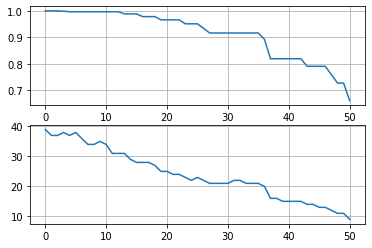

In [8]:

plt.subplot(2,1,1)
plt.plot(package_thresholds,found_counts/found_counts[0])
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(package_thresholds,target_counts)
# plt.yscale('log')
# plt.ylim(1, 1000)
plt.grid(True)


22


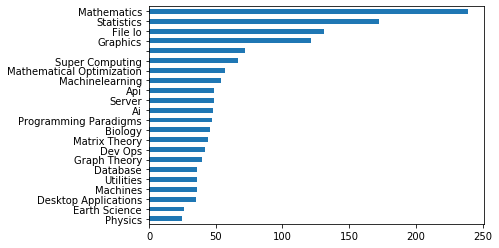

In [9]:
chosen_threshold = 24
print(target_counts[chosen_threshold])
reset_target(chosen_threshold)

make_barh(cur_decibans["target"], 32)

In [10]:
cur_decibans = cur_decibans[cur_decibans["target"] != ""]

In [11]:
cur_decibans

,name,url,category,sub_category,target
0,AAM,https://github.com/dfdx/AAM.jl,Graphics,Graphics,Graphics
1,ABCDistances,https://github.com/dennisprangle/ABCDistances.jl,Statistics,Bayesian,Statistics
2,AbstractTensors,https://github.com/chakravala/AbstractTensors.jl,Mathematics,Geometry,Mathematics
3,AbstractTrees,https://github.com/Keno/AbstractTrees.jl,Mathematics,GraphTheory,GraphTheory
5,Accumulo,https://github.com/JuliaDB/Accumulo.jl,Database,Distributed,Database
...,...,...,...,...,...
1903,YT,https://github.com/jzuhone/YT.jl,Graphics,GraphicalPlotting,Graphics
1905,ZChop,https://github.com/jlapeyre/ZChop.jl,Mathematics,DISCRETEMATH,Mathematics
1908,Zlib,https://github.com/dcjones/Zlib.jl,Utilities,FileCompression,Utilities
1909,ZMQ,https://github.com/JuliaLang/ZMQ.jl,Server,Middleware,Server


In [12]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import EnsembleVoteClassifier
import xgboost as xgb


In [13]:

cur_names = cur_decibans.name.reset_index(drop=True)
y = cur_decibans["target"].reset_index(drop=True)
X = cur_readme_data.loc[cur_names]["readme"].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [14]:
cur_count_vectorizer = CountVectorizer(
  strip_accents='unicode', 
  max_df=1/10, 
  min_df=2,
  ngram_range=(1, 3),
  tokenizer=custom_tokenizer,
  max_features=2**14
)

cur_classifiers = [
#     xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, nthread=-1),
    CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=3, method='isotonic'),
    MultinomialNB(fit_prior=False),
    RandomForestClassifier(n_jobs=-1, n_estimators=1000)
]

cur_clfs = []

for cur_classifier in cur_classifiers:
    cur_clfs.append(cur_classifier)

cur_ensemble = EnsembleVoteClassifier(clfs=cur_clfs, voting='soft')

cur_steps = [
    cur_count_vectorizer,
    TfidfTransformer(),
    ADASYN(),
    cur_ensemble
]

cur_pipeline = make_pipeline(*cur_steps)

cur_pipeline.fit(X_train, y_train)

cur_pipeline.score(X_test, y_test)


/usr/local/lib/python3.7/site-packages/sklearn/calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/sklearn/calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


0.55

In [15]:
for cur_index, cur_row, cur_yy in zip(X_test.index, cur_pipeline.predict_proba(X_test), y_test):
    cur_indices = list(reversed(np.argsort(cur_row)))
    
    if cur_row[cur_indices[0]] + cur_row[cur_indices[1]] < 0.7 : continue
    
    if cur_row[cur_indices[0]] > 2 * cur_row[cur_indices[1]] :
        print(cur_names.iloc[cur_index], " - ", cur_pipeline.classes_[np.argmax(cur_row)] , " - ", cur_yy)
    else: 
        print(cur_names.iloc[cur_index], " - ", [
        cur_pipeline.classes_[cur_indices[0]], cur_pipeline.classes_[cur_indices[1]]
        ] , " - ", cur_yy)
#     if cur_row[]
#     print(, cur_row[cur_indices[0]], cur_row[cur_indices[1]])
#     if np.max(cur_row) < 1/2 : continue

/usr/local/lib/python3.7/site-packages/sklearn/calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/sklearn/calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


DecisionTree  -  MACHINELEARNING  -  MACHINELEARNING
ParallelAccelerator  -  Super-Computing  -  Super-Computing
TimeModels  -  Statistics  -  Statistics
SGEArrays  -  Super-Computing  -  Super-Computing
Measurements  -  Physics  -  Mathematics
Xpress  -  MathematicalOptimization  -  MathematicalOptimization
FANN  -  AI  -  AI
ASTInterpreter2  -  Programming-Paradigms  -  DesktopApplications
GraphVisualize  -  Graphics  -  Graphics
IntervalTrees  -  FileIO  -  Biology
PlotlyJS  -  API  -  API
IniFile  -  ['Utilities', 'FileIO']  -  Programming-Paradigms
FunHPC  -  Super-Computing  -  Super-Computing
JuMP  -  MathematicalOptimization  -  MathematicalOptimization
Redis  -  Database  -  Database
MLDatasets  -  MACHINELEARNING  -  MACHINELEARNING
ParquetFiles  -  FileIO  -  FileIO
Earth  -  Statistics  -  Statistics
JointMoments  -  Statistics  -  Mathematics
SparseVectors  -  Mathematics  -  Mathematics
ScikitLearnBase  -  MACHINELEARNING  -  MACHINELEARNING
Blink  -  Server  -  DesktopAp